In [12]:
import numpy as np
import pandas as pd

# modeling utilities
import scipy.stats as stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn import  linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline


sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [2]:
df = pd.read_csv('hour.csv')

df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

# date time conversion
df['datetime'] = pd.to_datetime(df.datetime)

# categorical variables
df['season'] = df.season.astype('category')
df['is_holiday'] = df.is_holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weather_condition'] = df.weather_condition.astype('category')
df['is_workingday'] = df.is_workingday.astype('category')
df['month'] = df.month.astype('category')
df['year'] = df.year.astype('category')
df['hour'] = df.hour.astype('category')

In [19]:
def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified column.
    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded
    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series
    """
    
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df

In [4]:
X, X_test, y, y_test = train_test_split(df.iloc[:,0:-3], df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


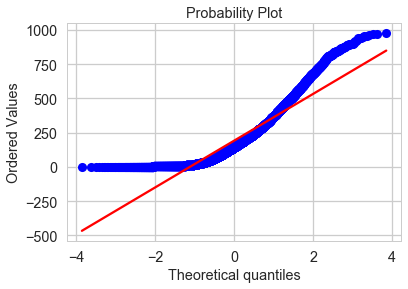

In [5]:
stats.probplot(y.total_count.tolist(), dist="norm", plot=plt)
plt.show()

In [6]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [7]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [8]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


In [9]:
train_df_new.dtypes

temp                    float64
humidity                float64
windspeed               float64
hour                   category
weekday                category
month                  category
year                   category
season_1                float64
season_2                float64
season_3                float64
season_4                float64
is_holiday_0            float64
is_holiday_1            float64
weather_condition_1     float64
weather_condition_2     float64
weather_condition_3     float64
weather_condition_4     float64
is_workingday_0         float64
is_workingday_1         float64
dtype: object

In [10]:
## Linear regression

X = train_df_new
y= y.total_count.values.reshape(-1,1)

lin_reg = linear_model.LinearRegression()

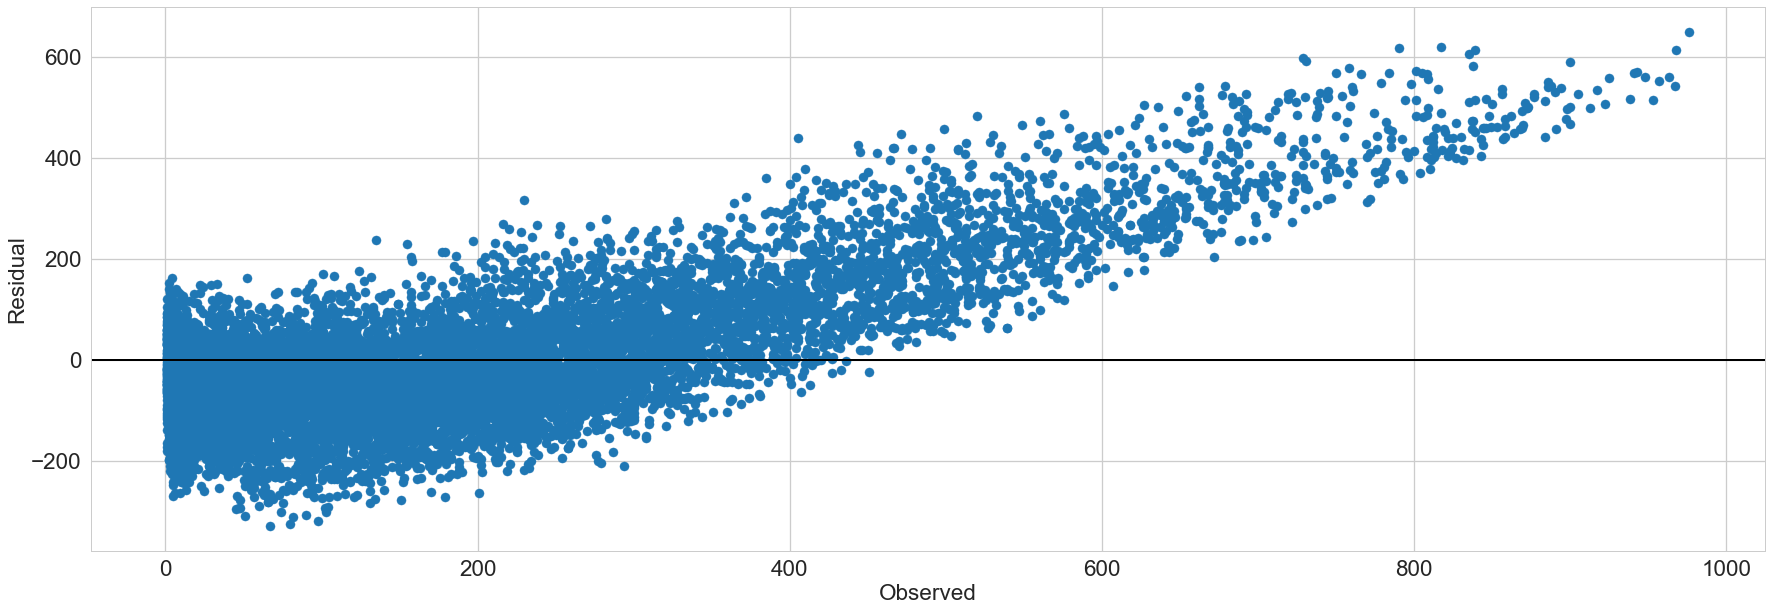

In [13]:
predicted = cross_val_predict(lin_reg, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, y-predicted)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [14]:
r2_scores = cross_val_score(lin_reg, X, y, cv=10)
mse_scores = cross_val_score(lin_reg, X, y, cv=10,scoring='neg_mean_squared_error')

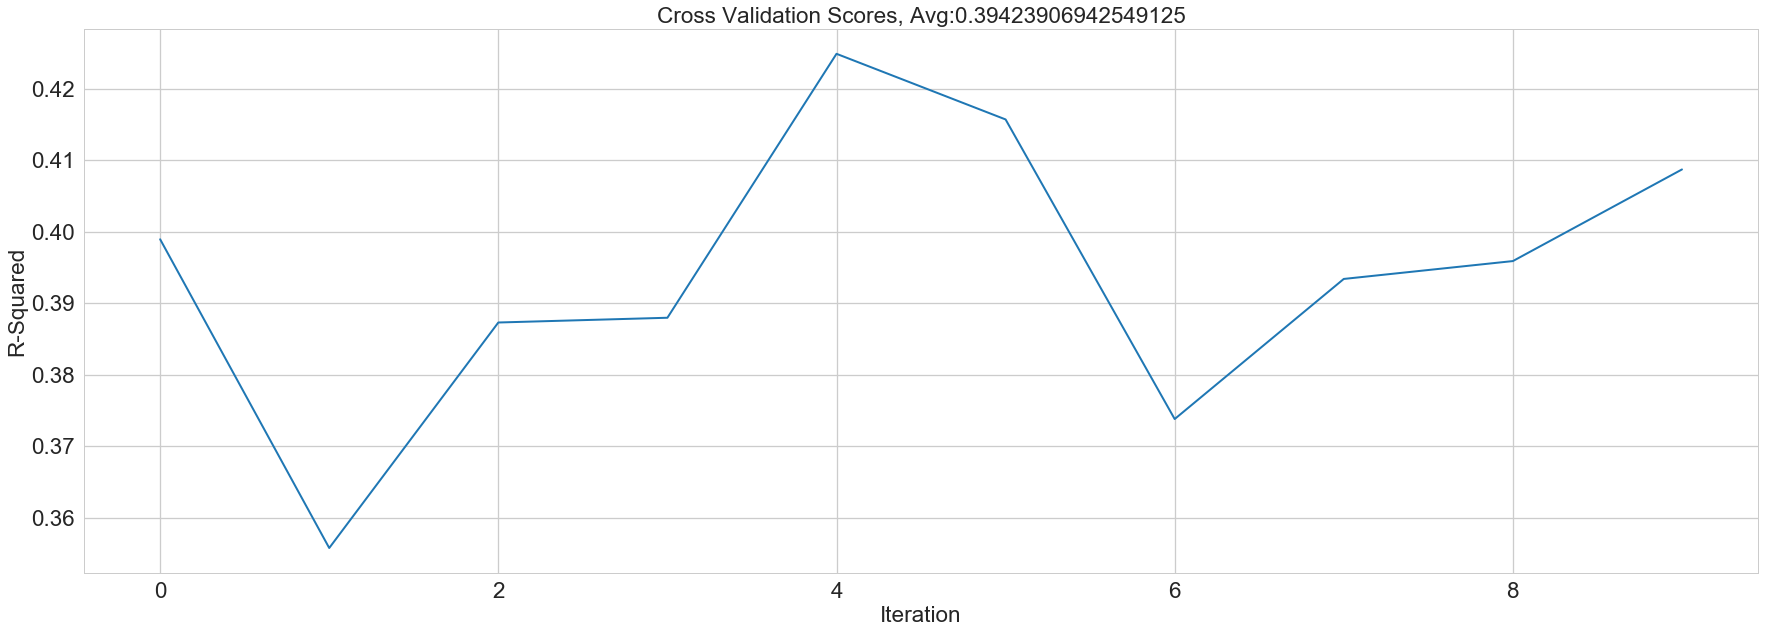

In [15]:
fig, ax = plt.subplots()
ax.plot([i for i in range(len(r2_scores))],r2_scores,lw=2)
ax.set_xlabel('Iteration')
ax.set_ylabel('R-Squared')
ax.title.set_text("Cross Validation Scores, Avg:{}".format(np.average(r2_scores)))
plt.show()

In [16]:
print("R-squared::{}".format(r2_scores))
print("MSE::{}".format(mse_scores))

R-squared::[0.39894459 0.35575732 0.3873037  0.38796861 0.42489499 0.41571164
 0.37379762 0.39339864 0.39589746 0.40871611]
MSE::[-19612.38349313 -20800.77110185 -20256.54013607 -18545.99033804
 -18746.57816436 -21015.35560028 -21549.12876053 -21567.27946203
 -21044.42416385 -18899.05989574]


In [17]:
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
# Test dataset

test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test, le,ohe, col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
                             for enc in test_encoded_attr_list \
                             if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [21]:
test_df_new.head()

,temp,humidity,windspeed,hour,weekday,month,year,season_1,season_2,season_3,season_4,is_holiday_0,is_holiday_1,weather_condition_1,weather_condition_2,weather_condition_3,weather_condition_4,is_workingday_0,is_workingday_1
0,0.80,0.27,0.1940,19,6,6,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.24,0.41,0.2239,20,1,1,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.32,0.66,0.2836,2,5,10,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.78,0.52,0.3582,19,2,5,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.26,0.56,0.3881,0,4,1,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

y_pred = lin_reg.predict(X_test)

residuals = y_test-y_pred

In [23]:
r2_score = lin_reg.score(X_test,y_test)

print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.4024409682673428
MSE: 19063.00


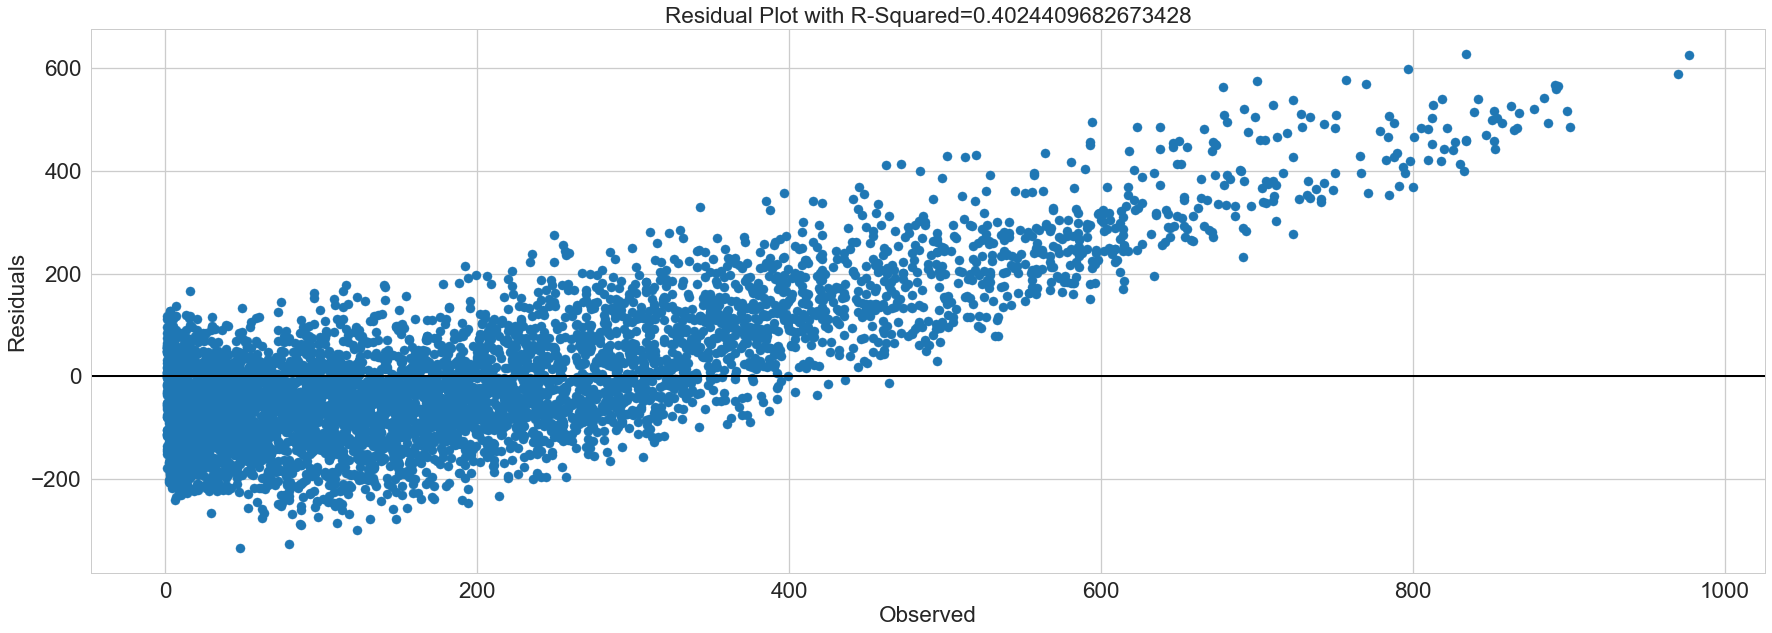

In [24]:
fig, ax = plt.subplots()
ax.scatter(y_test, residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residuals')
ax.title.set_text("Residual Plot with R-Squared={}".format(np.average(r2_score)))
plt.show()